Group Members: Sinny Ye (sy544), Brian Liu (bjl229), Caio Teig (cb733)


**Importing Packages**

In [33]:
import numpy as np
import pandas as pd
import duckdb
import seaborn
import time
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression


**Uploading CSV Files**

In [7]:
VTI_df = pd.read_csv('VTI10Y.csv')
SPY_df = pd.read_csv('SPY10Y.csv')

**Cleaning and Merging Files:**
1) Making sure there aren't any unnecessary columns in the dataframe
2) Merging VTI and SPY into one dataframe (TotalIndex)
3) Renaming Columns

In [12]:
VTI_df.columns = VTI_df.columns.str.strip()
SPY_df.columns = SPY_df.columns.str.strip()
VTI_df['Date'] = pd.to_datetime(VTI_df['Date'], format='%Y-%m-%d')
SPY_df['Date'] = pd.to_datetime(SPY_df['Date'], format='%Y-%m-%d')

VTIPrices = VTI_df[['Date','Open']] 
SPYPrices = SPY_df[['Date','Open']]
TotalIndex = duckdb.sql('\
    SELECT VTIPrices.Date, VTIPrices.Open, SPYPrices.Open \
    FROM VTIPrices INNER JOIN SPYPrices \
    ON VTIPrices.Date = SPYPrices.Date \
    ORDER BY SPYPrices.Date;').df()
TotalIndex.rename(columns={'Open': 'VTI','Open_1': 'SPY'}, inplace=True)

**Plotting Prices Chronologically for VTI and SPY**

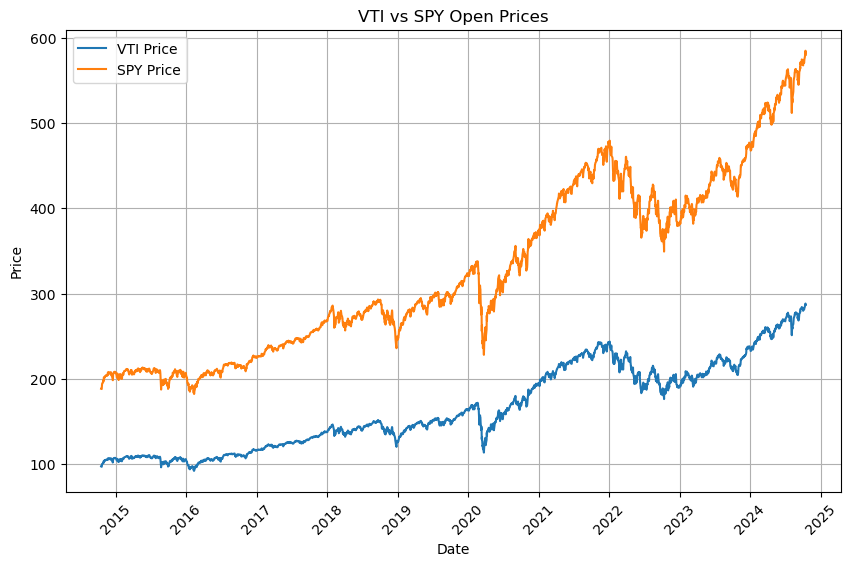

In [22]:
plt.figure(figsize=(10,6))
plt.plot(TotalIndex['Date'], TotalIndex['VTI'], label='VTI Price')
plt.plot(TotalIndex['Date'], TotalIndex['SPY'], label='SPY Price')
plt.title('VTI vs SPY Open Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.xticks(rotation=45)
plt.show()

**Computing Statistics**

In [15]:
TotalIndex['VTI_Returns'] = TotalIndex['VTI'].pct_change()
TotalIndex['SPY_Returns'] = TotalIndex['SPY'].pct_change()
TotalIndex.fillna(0, inplace=True)

vti_mean = TotalIndex['VTI_Returns'].mean()
vti_std = TotalIndex['VTI_Returns'].std()
vti_min = TotalIndex['VTI_Returns'].min()
vti_max = TotalIndex['VTI_Returns'].max()
spy_mean = TotalIndex['SPY_Returns'].mean()
spy_std = TotalIndex['SPY_Returns'].std()
spy_min = TotalIndex['SPY_Returns'].min()
spy_max = TotalIndex['SPY_Returns'].max()

stats_df = pd.DataFrame({
    'Statistic': ['Mean', 'Standard Deviation', 'Minimum', 'Maximum'],
    'VTI': [vti_mean, vti_std, vti_min, vti_max],
    'SPY': [spy_mean, spy_std, spy_min, spy_max]
})

stats_df

,Statistic,VTI,SPY
0,Mean,0.000489,0.000503
1,Standard Deviation,0.010912,0.010595
2,Minimum,-0.086744,-0.087994
3,Maximum,0.066885,0.063489


**Plotting the Daily Returns**

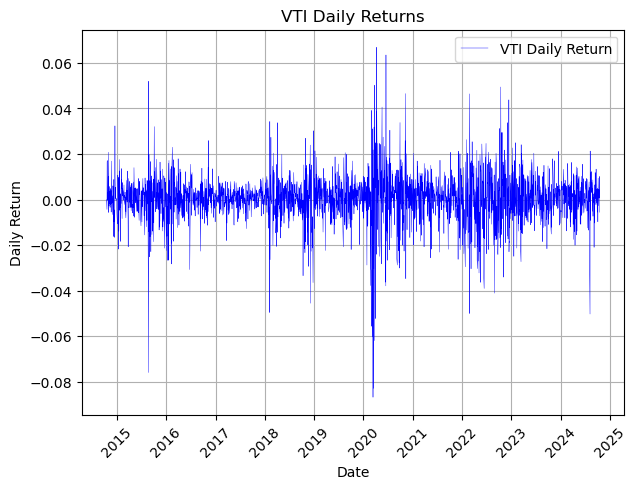

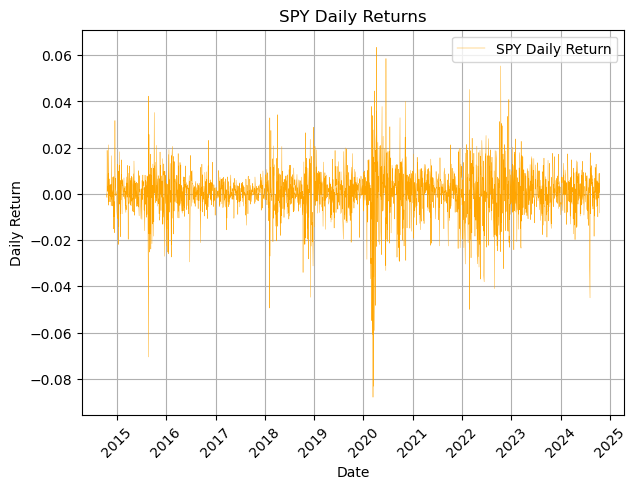

In [21]:
# First figure for VTI
plt.figure(figsize=(7, 5)) 
plt.plot(TotalIndex['Date'], TotalIndex['VTI_Returns'], color='blue', 
         label='VTI Daily Return', linewidth=0.3)
plt.title('VTI Daily Returns')
plt.xlabel('Date')
plt.ylabel('Daily Return')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.show()

# Second figure for SPY
plt.figure(figsize=(7, 5))
plt.plot(TotalIndex['Date'], TotalIndex['SPY_Returns'], color='orange', 
         label='SPY Daily Return', linewidth=0.3)
plt.title('SPY Daily Returns')
plt.xlabel('Date')
plt.ylabel('Daily Return')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.show()

**Linear Regression**
1) Create new Date_Ordinal, stores date as a number since date of inception
2) asd

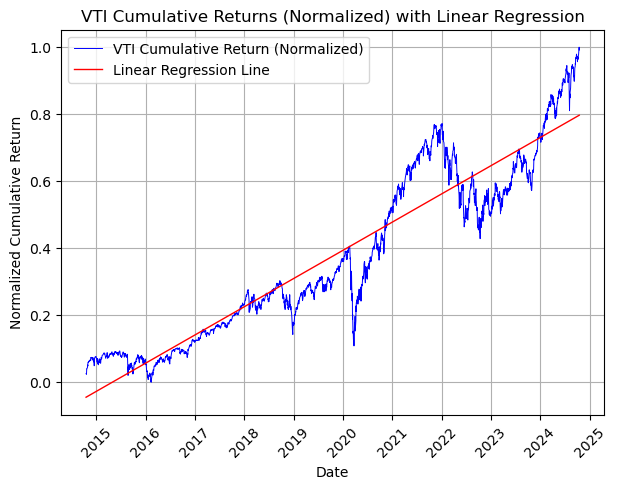

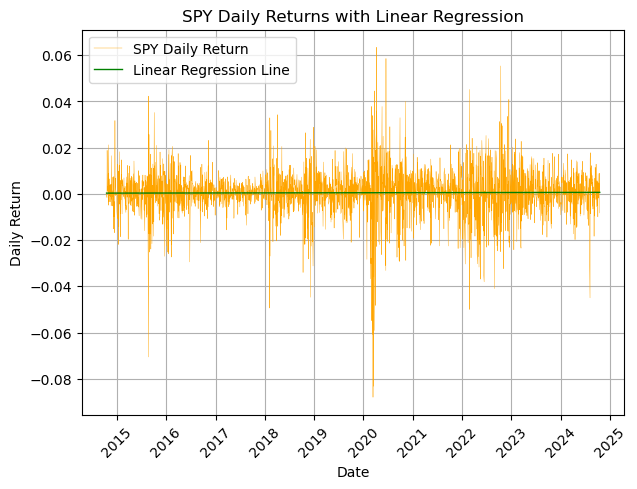

In [44]:
TotalIndex['Date_Ordinal'] = pd.to_datetime(TotalIndex['Date']).map(pd.Timestamp.toordinal)
TotalIndex['VTI_Cumulative'] = (1 + TotalIndex['VTI_Returns']).cumprod() - 1
TotalIndex['SPY_Cumulative'] = (1 + TotalIndex['SPY_Returns']).cumprod() - 1

vti_min = TotalIndex['VTI_Cumulative'].min()
vti_max = TotalIndex['VTI_Cumulative'].max()
TotalIndex['VTI_Cumulative_Normalized'] = (TotalIndex['VTI_Cumulative'] - vti_min) / (vti_max - vti_min)

x_vti = TotalIndex['Date_Ordinal'].values.reshape(-1, 1)
y_vti_cum_norm = TotalIndex['VTI_Cumulative_Normalized'].values

vti_model = LinearRegression()

vti_model.fit(x_vti, y_vti_cum_norm)
vti_pred_cum_norm = vti_model.predict(x_vti)

plt.figure(figsize=(7, 5))
plt.plot(TotalIndex['Date'], TotalIndex['VTI_Cumulative_Normalized'], color='blue', label='VTI Cumulative Return (Normalized)', linewidth=0.7)
plt.plot(TotalIndex['Date'], vti_pred_cum_norm, color='red', label='Linear Regression Line', linewidth=1)
plt.title('VTI Cumulative Returns (Normalized) with Linear Regression')
plt.xlabel('Date')
plt.ylabel('Normalized Cumulative Return')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.show()






X_spy = TotalIndex['Date_Ordinal'].values.reshape(-1, 1)
y_spy = TotalIndex['SPY_Returns'].values


# Perform linear regression for SPY
spy_model = LinearRegression()
spy_model.fit(X_spy, y_spy)

# Predict values for SPY
spy_pred = spy_model.predict(X_spy)

# Plot SPY returns and regression line
plt.figure(figsize=(7, 5))
plt.plot(TotalIndex['Date'], TotalIndex['SPY_Returns'], color='orange', label='SPY Daily Return', linewidth=0.3)
plt.plot(TotalIndex['Date'], spy_pred, color='green', label='Linear Regression Line', linewidth=1)
plt.title('SPY Daily Returns with Linear Regression')
plt.xlabel('Date')
plt.ylabel('Daily Return')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.show()